### Input Redshift Cluster Endpoint and User
Please input your redshift cluster endpoint and existing user on that cluster.

In [1]:
REDSHIFT_ENDPOINT = 'redshift-cluster.xxxxxxxxxx.us-east-1.redshift.amazonaws.com:5439/dev'
REDSHIFT_USER="awsuser"

### Setup Run SQL function using Redshift Data API to get SQL query output directly into pandas dataframe
In this step, we are creating function run_sql, which we will use to get SQL query output directly into pandas dataframe. We will also use this function to run DDL statements

In [2]:

import boto3
import time
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

session = boto3.session.Session()
region = session.region_name


def run_sql(sql_text):
    client = boto3.client("redshift-data")
    res = client.execute_statement(Database=REDSHIFT_ENDPOINT.split('/')[1], DbUser=REDSHIFT_USER, Sql=sql_text,
                                   ClusterIdentifier=REDSHIFT_ENDPOINT.split('.')[0])
    query_id = res["Id"]
    done = False
    while not done:
        time.sleep(1)
        status_description = client.describe_statement(Id=query_id)
        status = status_description["Status"]
        if status == "FAILED":
            raise Exception('SQL query failed:' + query_id + ": " + status_description["Error"])
        elif status == "FINISHED":
            if status_description['ResultRows']>0:
                results = client.get_statement_result(Id=query_id)
                column_labels = []
                for i in range(len(results["ColumnMetadata"])): column_labels.append(results["ColumnMetadata"][i]['label'])
                records = []
                for record in results.get('Records'):
                    records.append([list(rec.values())[0] for rec in record])
                df = pd.DataFrame(np.array(records), columns=column_labels)
                return df
            else:
                return query_id


## Data Preparation Script
Data preparation script to be run on Redshift

In [3]:
setup_script = """
DROP TABLE IF EXISTS ridership CASCADE;
DROP TABLE IF EXISTS weather CASCADE;
DROP TABLE IF EXISTS holiday CASCADE;
DROP TABLE IF EXISTS trip_data CASCADE;

CREATE TABLE IF NOT EXISTS ridership
( trip_id               INT
, trip_duration_seconds INT
, trip_start_time       timestamp
, trip_stop_time        timestamp
, from_station_name     VARCHAR(50)
, to_station_name       VARCHAR(50)
, from_station_id       SMALLINT
, to_station_id         SMALLINT
, user_type             VARCHAR(20));

CREATE TABLE IF NOT EXISTS weather
( longitude_x         DECIMAL(5,2)
, latitude_y          DECIMAL(5,2)
, station_name        VARCHAR(20)
, climate_id          BIGINT
, datetime_utc        TIMESTAMP
, weather_year        SMALLINT
, weather_month       SMALLINT
, weather_day         SMALLINT
, time_utc            VARCHAR(5)
, temp_c              DECIMAL(5,2)
, temp_flag           VARCHAR(1)
, dew_point_temp_c    DECIMAL(5,2)
, dew_point_temp_flag VARCHAR(1)
, rel_hum             SMALLINT
, rel_hum_flag        VARCHAR(1)
, precip_amount_mm    DECIMAL(5,2)
, precip_amount_flag  VARCHAR(1)
, wind_dir_10s_deg    VARCHAR(10)
, wind_dir_flag       VARCHAR(1)
, wind_spd_kmh        VARCHAR(10)
, wind_spd_flag       VARCHAR(1)
, visibility_km       VARCHAR(10)
, visibility_flag     VARCHAR(1)
, stn_press_kpa       DECIMAL(5,2)
, stn_press_flag      VARCHAR(1)
, hmdx                SMALLINT
, hmdx_flag           VARCHAR(1)
, wind_chill          VARCHAR(10)
, wind_chill_flag     VARCHAR(1)
, weather             VARCHAR(10));

CREATE TABLE IF NOT EXISTS holiday
( holiday_date  DATE
, description VARCHAR(100));


COPY ridership FROM 
's3://redshift-ml-bikesharing-data/bike-sharing-data/ridership/'
IAM_ROLE 'arn:aws:iam::<accountid>:role/RedshiftML'
FORMAT csv IGNOREHEADER 1 DATEFORMAT 'auto' TIMEFORMAT 'auto' REGION 'us-west-2' gzip;

COPY weather FROM
's3://redshift-ml-bikesharing-data/bike-sharing-data/weather/'
IAM_ROLE 'arn:aws:iam::<accountid>:role/RedshiftML'
FORMAT csv IGNOREHEADER 1 DATEFORMAT 'auto' TIMEFORMAT 'auto' REGION 'us-west-2' gzip;

COPY holiday FROM
's3://redshift-ml-bikesharing-data/bike-sharing-data/holiday/'
IAM_ROLE 'arn:aws:iam::<accountid>:role/RedshiftML'
FORMAT csv IGNOREHEADER 1 DATEFORMAT 'auto' TIMEFORMAT 'auto' REGION 'us-west-2' gzip;

CREATE OR REPLACE VIEW ridership_view AS
SELECT
    trip_time
    , trip_count
    , TO_CHAR(trip_time,'hh24') ::INT trip_hour
    , TO_CHAR(trip_time, 'dd') :: INT trip_day
    , TO_CHAR(trip_time, 'mm') :: INT trip_month
    , TO_CHAR(trip_time, 'yy') :: INT trip_year
    , TO_CHAR(trip_time, 'q') :: INT trip_quarter
    , TO_CHAR(trip_time, 'w') :: INT trip_month_week
    , TO_CHAR(trip_time, 'd') :: INT trip_week_day
FROM  
    (SELECT  
         CASE
           WHEN TRUNC(r.trip_start_time) < '2017-07-01'::DATE
           THEN CONVERT_TIMEZONE('US/Eastern', DATE_TRUNC('hour',r.trip_start_time))
           ELSE DATE_TRUNC('hour',r.trip_start_time)
         END trip_time
         , COUNT(1) trip_count
     FROM    
         ridership r
     WHERE    r.trip_duration_seconds BETWEEN 60 AND 60 * 60 * 24
     GROUP BY
         1);

CREATE OR REPLACE VIEW weather_view AS
SELECT  
    CONVERT_TIMEZONE('US/Eastern', 
      DATE_TRUNC('hour',datetime_utc)) daytime
    , ROUND(AVG(temp_c)) temp_c
    , ROUND(AVG(precip_amount_mm)) precip_amount_mm
FROM weather
GROUP BY 1;

DROP TABLE IF EXISTS trip_data;
CREATE TABLE trip_data AS 
SELECT         
   r.trip_time
  ,r.trip_count
  ,r.trip_hour
  ,r.trip_day
  ,r.trip_month
  ,r.trip_year
  ,r.trip_quarter
  ,r.trip_month_week
  ,r.trip_week_day
  ,w.temp_c
  ,w.precip_amount_mm
  ,CASE
      WHEN h.holiday_date IS NOT NULL
      THEN 1
      WHEN TO_CHAR(r.trip_time,'D')::INT IN (1,7)
      THEN 1
      ELSE 0
    END is_holiday
  , ROW_NUMBER() OVER (ORDER BY RANDOM()) serial_number
FROM           
  ridership_view r
JOIN            weather_view w
  ON ( r.trip_time = w.daytime )
LEFT OUTER JOIN holiday h
  ON ( TRUNC(r.trip_time) = h.holiday_date );

"""

### Run data preparation script in Redshift

In [4]:
for sql_text in setup_script.split(";"):
    run_sql(sql_text);

### Read SQL output with Pandas Dataframe

In [5]:
df = run_sql("select trip_count, trip_time from trip_data");
df.head(10)

,trip_count,trip_time
0,232,2017-11-24 07:00:00.0
1,17,2017-07-12 04:00:00.0
2,74,2017-02-16 13:00:00.0
3,229,2017-04-27 18:00:00.0
4,61,2018-01-15 12:00:00.0
5,140,2017-12-05 11:00:00.0
6,225,2018-04-02 09:00:00.0
7,20,2017-12-29 10:00:00.0
8,287,2018-05-10 14:00:00.0
9,334,2017-08-31 12:00:00.0


In [6]:
df.describe()

,trip_count,trip_time
count,17306,17306
unique,1066,17306
top,2,2017-11-28 20:00:00.0
freq,239,1


### Visualize data using matplotlib

Text(0.5, 1.0, 'trip count histogram')

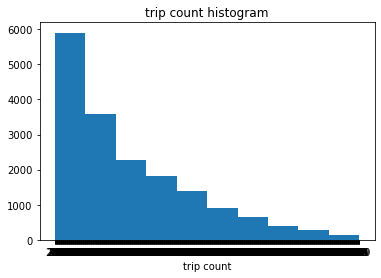

In [7]:
plt.hist(df.trip_count)
plt.xlabel('trip count')
plt.title('trip count histogram')

In [8]:
df = run_sql("select round(trip_count/100) trip_count, trip_hour from trip_data");
df.head(10)


,trip_count,trip_hour
0,1.0,11.0
1,10.0,17.0
2,0.0,3.0
3,0.0,5.0
4,1.0,14.0
5,2.0,19.0
6,2.0,15.0
7,1.0,9.0
8,1.0,23.0
9,0.0,4.0


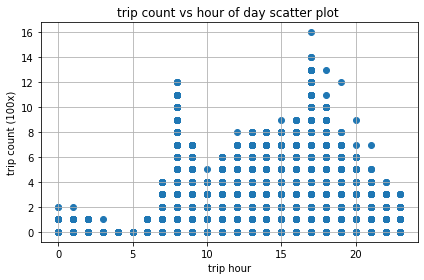

In [9]:
plt.scatter(df.trip_hour,df.trip_count)
plt.ylabel('trip count (100x)')
plt.xlabel('trip hour')
plt.title('trip count vs hour of day scatter plot ')
plt.grid(True)
plt.tight_layout()

### Run Create Model statement to create a new ML model with REdshift ML

In [ ]:
run_sql("""
CREATE MODEL predict_rental_count 
FROM (SELECT
 trip_count,trip_hour,trip_day,trip_month,trip_year,trip_quarter,
 trip_month_week, trip_week_day, temp_c, precip_amount_mm, is_holiday
FROM trip_data)
TARGET trip_count
FUNCTION predict_rental_count
IAM_ROLE 'arn:aws:iam::<accountid>:role/RedshiftML'
PROBLEM_TYPE regression
OBJECTIVE 'mse'
SETTINGS (s3_bucket 'redshiftml-<your-account-id>')
""");

### View Model Progress 

In [11]:
df = run_sql("SHOW MODEL predict_rental_count")
df

,Key,Value
0,Model Name,predict_rental_count
1,Schema Name,public
2,Owner,awsuser
3,Creation Time,"Tue, 06.07.2021 14:56:58"
4,Model State,READY
5,Training Job Status,MaxAutoMLJobRuntimeReached
6,validation:mse,1504.939453
7,Estimated Cost,5.096579
8,,
9,TRAINING DATA:,


### Run Prediction and compare actual vs predicted


In [12]:
df = run_sql("""
SELECT trip_time, actual_count, predicted_count, ( actual_count - predicted_count ) difference
FROM  
(SELECT
 trip_time
,trip_count AS actual_count
,PREDICT_RENTAL_COUNT (trip_hour, trip_day, trip_month, trip_year, trip_quarter, trip_month_week, trip_week_day, temp_c, precip_amount_mm, is_holiday) predicted_count
FROM trip_data
) LIMIT 5;
""");
df


,trip_time,actual_count,predicted_count,difference
0,2018-01-01 08:00:00.0,4,13.333012580871582,-9.333012580871582
1,2018-04-27 10:00:00.0,200,205.99017333984375,-5.99017333984375
2,2018-04-19 22:00:00.0,84,76.41361999511719,7.5863800048828125
3,2018-08-04 17:00:00.0,830,826.263671875,3.736328125
4,2018-04-04 23:00:00.0,33,30.671052932739258,2.328947067260742
